/home/mobrrei/miniconda3/envs/svd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  7.85it/s]
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


Loading cached dataset from cache/wikitext2_64_2048_42_dict.pt
Calibration data loaded.
model.layers.3.mlp.gate_proj


Getting activations for model.layers.3.mlp.gate_proj: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


Applying GSVD to model.layers.3.mlp.gate_proj with low rank: 2178
Training GSVD layer for model.layers.3.mlp.gate_proj...


Finished training GSVD layer for model.layers.3.mlp.gate_proj. Loss: 0.059030828066170216


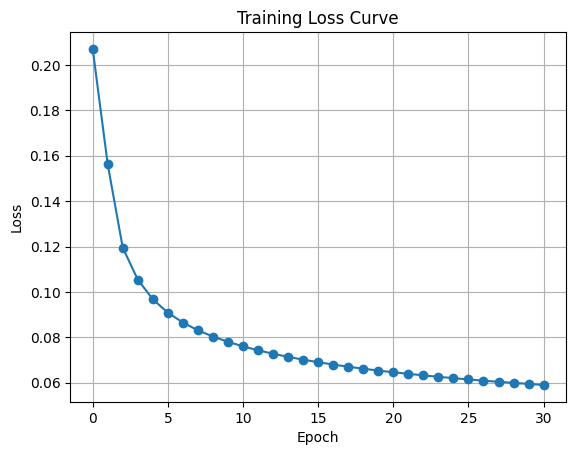

In [1]:
import torch
from torch import nn
from transformers import AutoModelForCausalLM, AutoTokenizer
from utils import (replace_module_by_name, get_calib_train_data,
                   get_truncate)
from modules import SVDLinearLayer, HybridLoss
from tqdm import tqdm
import gc # --- CHANGE: Import garbage collector

RATIO = 0.6
CALIB_DATASET = "wikitext2"
model_name = "huggyllama/llama-7b"

model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16)
tokenizer = AutoTokenizer.from_pretrained(model_name)
SEQLEN = model.config.max_position_embeddings
BATCH_SIZE = 4
CALIB_SAMPLES = 64
SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

calib_data = get_calib_train_data(name=CALIB_DATASET,
                                  tokenizer=tokenizer,
                                  seqlen=SEQLEN,
                                  batch_size=BATCH_SIZE,
                                  nsamples=CALIB_SAMPLES,
                                  seed=SEED)
print("Calibration data loaded.")

GRADIENT_EPOCHS = 30
CALIB_BATCH_SIZE = 8
GRADS_PATH = None  # Path to the CSV file containing gradient importance weights, or None if not used
activation_fn = nn.SiLU()
grads = {}

linear_layer_names = []
for name, module in model.named_modules():
    if isinstance(module, nn.Linear) and name != "lm_head":
        linear_layer_names.append(name)

target_layers = [
    "model.layers.3.mlp.gate_proj"]

for name in reversed(linear_layer_names):
    if name in target_layers:
        print(name)
            
        activations = []
        def forward_hook(module, input, output):
            activations.append(input[0].detach().cpu())

        hook = module.register_forward_hook(forward_hook)
        model.eval()
        model.half()
        model.to(DEVICE)
        with torch.no_grad():
            for batch in tqdm(calib_data, desc=f"Getting activations for {name}"):
                input_ids = batch['input_ids'].to(DEVICE)
                attention_mask = batch['attention_mask'].to(DEVICE)
                model(input_ids=input_ids, attention_mask=attention_mask, use_cache=False)
        hook.remove()

        # --- CHANGE: Aggressively clear VRAM after activation gathering ---
        model.to('cpu')
        gc.collect()
        torch.cuda.empty_cache()

        activations = torch.cat(activations, dim=0).float()

        module.to(DEVICE).float()

        W = module.weight.data.clone().detach().to(DEVICE)
        b = module.bias.data.clone().detach().to(DEVICE) if module.bias is not None else None

        out_features, in_features = W.shape
        low_rank = get_truncate(in_features, out_features, RATIO)
        print(f"Applying GSVD to {name} with low rank: {low_rank}")

        U, S, VT = torch.linalg.svd(W, full_matrices=False)
        s_sqrt = torch.diag(torch.sqrt(S))
        u_parameter = torch.matmul(U[:, :low_rank], s_sqrt[:low_rank, :low_rank])
        vt_parameter = torch.matmul(s_sqrt[:low_rank, :low_rank], VT[:low_rank, :])

        svd_layer = SVDLinearLayer(
            vt_parameter=vt_parameter,
            u_parameter=u_parameter,
            bias=b,
        )
        svd_layer.to(DEVICE).train()
        
        # If the layer is a mlp.gate_proj let's calibrate it with the activation function to ensure a more accurate representation
        if 'mlp.gate_proj' in name:
            activation = activation_fn
        else:
            activation = nn.Identity()

        del W, U, S, VT, s_sqrt, u_parameter, vt_parameter, b
        torch.cuda.empty_cache()
        
        importance_weights = grads[name] if GRADS_PATH is not None else None
        #Ensure no 0 importance weights are passed, if they are, use a threshold of 0.01
        if importance_weights is not None:
            importance_weights = torch.where(importance_weights < 0.01, torch.tensor(0.01, device=importance_weights.device), importance_weights)

        loss_fn = HybridLoss(weights=importance_weights,
                            alpha=0.5,  # Adjust alpha as needed
                            reduction="mean").to(DEVICE)
        
        optimizer = torch.optim.AdamW(svd_layer.parameters(), lr=1e-4, weight_decay=1e-3)

        print(f"Training GSVD layer for {name}...")
        activation_dataset = torch.utils.data.TensorDataset(activations)
        activation_loader = torch.utils.data.DataLoader(
            activation_dataset,
            batch_size=CALIB_BATCH_SIZE,
            shuffle=True
        )
        
        loss_log = []
        # Initial loss before training
        with torch.no_grad():
            total_loss = 0.0
            for batch_tuple in activation_loader:
                batch = batch_tuple[0].to(DEVICE)
                output = activation(svd_layer(batch))
                target = activation(module(batch))
                loss = loss_fn(output, target)
                total_loss += loss.item() * batch.size(0)
            initial_loss = total_loss / len(activation_dataset)
            loss_log.append(initial_loss)
        
        for epoch in range(GRADIENT_EPOCHS):
            epoch_loss_log = []
            pbar = tqdm(activation_loader, desc=f"Epoch {epoch+1}/{GRADIENT_EPOCHS}", leave=False)

            for batch_tuple in pbar:
                batch = batch_tuple[0].to(DEVICE)
                optimizer.zero_grad()
                output = activation(svd_layer(batch))
                # The target needs to be computed on the GPU with the original module
                with torch.no_grad():
                    target = activation(module(batch))
                loss = loss_fn(output, target)
                loss.backward()
                optimizer.step()
                epoch_loss_log.append(loss.item())
                pbar.set_postfix({'loss': loss.item()})
            loss_log.append(sum(epoch_loss_log) / len(epoch_loss_log))

        print(f"Finished training GSVD layer for {name}. Loss: {loss_log[-1]}")
        
        svd_layer.to('cpu').eval().half()
        replace_module_by_name(model, name, svd_layer)
        
        # --- CHANGE: Clean up and save checkpoint ---
        del svd_layer, activations, loss_fn, optimizer, module
        gc.collect()
        torch.cuda.empty_cache()

# Plot loss curve
import matplotlib.pyplot as plt
plt.plot(range(0, GRADIENT_EPOCHS + 1), loss_log, marker='o')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [1]:
import torch
from torch import nn
from transformers import AutoModelForCausalLM, AutoTokenizer
from utils import (replace_module_by_name, get_calib_train_data,
                   get_truncate)
from modules import SVDLinearLayer, HybridLoss
from tqdm import tqdm
import gc
import copy
import matplotlib.pyplot as plt

# --- Your existing setup code ---
RATIO = 0.6
CALIB_DATASET = "wikitext2"
model_name = "huggyllama/llama-7b"

model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16)
tokenizer = AutoTokenizer.from_pretrained(model_name)
SEQLEN = model.config.max_position_embeddings
BATCH_SIZE = 4
CALIB_SAMPLES = 10
SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

calib_data = get_calib_train_data(name=CALIB_DATASET,
                                  tokenizer=tokenizer,
                                  seqlen=SEQLEN,
                                  batch_size=BATCH_SIZE,
                                  nsamples=CALIB_SAMPLES,
                                  seed=SEED)
print("Calibration data loaded.")

GRADIENT_EPOCHS = 30
CALIB_BATCH_SIZE = 8
GRADS_PATH = None
activation_fn = nn.SiLU()
grads = {}

target_modules = [
    "model.layers.3.self_attn"
]

modules_names = []
for name, module in model.named_modules():
    if name in target_modules:
        modules_names.append(name)

def get_module_linear_layers(module):
    linear_layers = {}
    for name, sub_module in module.named_modules():
        if isinstance(sub_module, nn.Linear):
            linear_layers[name] = sub_module
    return linear_layers

print("Target modules for attention:", modules_names)

# --- Start of the new calibration logic ---

for name in reversed(modules_names):
    original_module = dict(model.named_modules())[name]
    print(f"Processing module: {name}")

    # 1. CAPTURE INPUT ACTIVATIONS AND ATTENTION MASKS
    activations = []
    attention_masks = [] # We need masks for the forward pass

    def forward_pre_hook(module, args, kwargs):
        activations.append(kwargs['hidden_states'].detach().cpu())
        # Capture the corresponding attention mask
        attention_masks.append(kwargs['attention_mask'].detach().cpu())
        return args, kwargs

    hook = original_module.register_forward_pre_hook(forward_pre_hook, with_kwargs=True)
    
    model.eval().half().to(DEVICE)
    with torch.no_grad():
        for batch in tqdm(calib_data, desc=f"Getting activations for {name}"):
            # We just need to run the forward pass to trigger the hook
            model(input_ids=batch['input_ids'].to(DEVICE),
                  attention_mask=batch['attention_mask'].to(DEVICE),
                  use_cache=False)
    hook.remove()

    model.to('cpu')
    gc.collect()
    torch.cuda.empty_cache()

    activations = torch.cat(activations, dim=0).float()
    attention_masks = torch.cat(attention_masks, dim=0)
    print(f"Captured activations shape: {activations.shape}")
    print(f"Captured attention masks shape: {attention_masks.shape}")

    # 2. CREATE THE SVD-REPLACED MODULE
    svd_module = copy.deepcopy(original_module)
    linear_layers = get_module_linear_layers(svd_module)
    print(f"Found {len(linear_layers)} linear layers in {name} to replace.")

    for lname, lmodule in linear_layers.items():
        W = lmodule.weight.data.clone()
        b = lmodule.bias.data.clone() if lmodule.bias is not None else None

        out_features, in_features = W.shape
        low_rank = get_truncate(in_features, out_features, RATIO)
        
        U, S, VT = torch.linalg.svd(W, full_matrices=False)
        s_sqrt = torch.diag(torch.sqrt(S))
        u_parameter = (U[:, :low_rank] @ s_sqrt[:low_rank, :low_rank])
        vt_parameter = (s_sqrt[:low_rank, :low_rank] @ VT[:low_rank, :])

        svd_layer = SVDLinearLayer(
            vt_parameter=vt_parameter,
            u_parameter=u_parameter,
            bias=b,
        )
        replace_module_by_name(svd_module, lname, svd_layer)
        del W, U, S, VT, s_sqrt, u_parameter, vt_parameter, b, svd_layer
        torch.cuda.empty_cache()
    
    # 3. SET UP FOR TRAINING
    original_module.to(DEVICE).float().eval()
    svd_module.to(DEVICE).float().train()

    # The optimizer now takes all parameters from the SVD module
    optimizer = torch.optim.AdamW(svd_module.parameters(), lr=1e-4, weight_decay=1e-3)
    loss_fn = HybridLoss(reduction="mean").to(DEVICE)

    # The dataset now contains both activations and masks
    activation_dataset = torch.utils.data.TensorDataset(activations, attention_masks)
    activation_loader = torch.utils.data.DataLoader(
        activation_dataset,
        batch_size=CALIB_BATCH_SIZE,
        shuffle=True
    )

    loss_log = []
    print(f"Calibrating all layers in {name} simultaneously...")

    # 4. RUN THE CALIBRATION LOOP
    for epoch in range(GRADIENT_EPOCHS):
        epoch_loss = 0.0
        pbar = tqdm(activation_loader, desc=f"Epoch {epoch+1}/{GRADIENT_EPOCHS}", leave=False)
        for act_batch, mask_batch in pbar:
            act_batch = act_batch.to(DEVICE)
            mask_batch = mask_batch.to(DEVICE)

            optimizer.zero_grad()

            # Get output from the SVD module
            # The output is a tuple (hidden_states, attn_weights, past_key_value)
            svd_output = svd_module(hidden_states=act_batch, attention_mask=mask_batch)[0]

            # Get target output from the original module
            with torch.no_grad():
                original_output = original_module(hidden_states=act_batch, attention_mask=mask_batch)[0]

            loss = loss_fn(svd_output, original_output)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})
        
        loss_log.append(epoch_loss / len(activation_loader))

    print(f"Finished calibrating {name}. Final Loss: {loss_log[-1]:.6f}")

    # 5. REPLACE THE ORIGINAL MODULE IN THE MAIN MODEL
    svd_module.to('cpu').eval().half()
    replace_module_by_name(model, name, svd_module)
    
    print("Module replaced in the main model.")

    # 6. CLEAN UP MEMORY
    del original_module, svd_module, activations, attention_masks, loss_fn, optimizer
    gc.collect()
    torch.cuda.empty_cache()

    # Plot loss curve for this module
    plt.plot(range(1, GRADIENT_EPOCHS + 1), loss_log, marker='o')
    plt.title(f'Calibration Loss Curve for {name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

/home/mobrrei/miniconda3/envs/svd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  7.75it/s]
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


Loading cached dataset from cache/wikitext2_10_2048_42_dict.pt
Calibration data loaded.
Target modules for attention: ['model.layers.3.self_attn']
Processing module: model.layers.3.self_attn


Getting activations for model.layers.3.self_attn:   0%|          | 0/3 [00:00<?, ?it/s]


AttributeError: 'NoneType' object has no attribute 'detach'